# **IST 736: Text Mining**

**Nikita Ramsey**


Homework #4

# Introduction:

For this assignment, we'll be using restaurant review data to create prediction models for lies and sentiment


We'll first start by installing and loading the necessary libraries.

In [1]:
pip install seaborn spacy nltk vaderSentiment pandas matplotlib contractions

In [2]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from textblob import TextBlob

from collections import Counter
from wordcloud import WordCloud

import string
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# **Data:**

This data was obtained from the an inclass resource and contains 92 rows and 3 columns.
The three columns include:


*   Lie (str)
*   Sentiment (str)
*   Review (str)



Here I'm going to load and review the data.

Loading the data

In [3]:
csv_file = 'deception_data_converted_final.tsv'
df = pd.read_csv(csv_file, delimiter="\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lie        92 non-null     object
 1   sentiment  92 non-null     object
 2   review     92 non-null     object
dtypes: object(3)
memory usage: 2.3+ KB


In [4]:
# Adjust display settings
pd.set_option('display.max_colwidth', None)

df.head()

,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'"
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'"
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'"
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '"
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '"


**Initial preprocessing:**

To begin the preprocessing of the text, this function will be used to get the data in a clean state.

In [5]:
import contractions

# Clean the text
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()  # Convert to lowercase and strip spaces

In [6]:
# Clean the text and add to dt
df['cleaned_text'] = df['review'].apply(clean_text)

# Compare text to ensure cleaning steps were applied
df['review']

,review
0,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'"
1,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'"
2,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'"
3,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '"
4,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '"
...,...
87,'Pastablities is a locally owned restaurant in Syracuse. The food is simple and homey and comforting. Their famous bread is baked daily and the bakery is right next door. The bread is soft and chewy and amazing with their homemade spicy tomato sauce. The paste and cheese that I had was cream and cooked to perfection. '
88,"'I like the Pizza at Dominoes for their special ingredients and the prices, they give out one of the best pizza\'s in town. I ordered Special Pepperoni Pizza (large) from the online portal which gives me a discount of 50\% for being a regular customer, they always provide a good quantity of cheese over the pizza, we generally do not need to add a topping of pizza cheese for cheese lovers compared to other places. The place has a nice ambient environment, it is generally empty as it has more delivery orders than dine in. Orders are processed very quickly and has a special taste to it. Cost friendly prices makes me pick it up as my best buy. Overall Rating : 5/5'"
89,'It was a really amazing Japanese restaurant. The waiter has friendly smile. The environment is very nice. And the food is fresh.'
90,"'How do I even pick a best experience at Joe\'s Noodle House? It\'s hard to find an authentic Chinese restaurant anywhere in the United States: what we think of as Chinese food is really American food with a few Chinese ingredients. (Chinese food is not usually deep-fried and is virtually never sweet.) A restaurant with a name like \'Joe\'s Noodle House\' doesn\'t sound that promising, but it\'s the best Sichuanese restaurant I\'ve been to in the United States. I\'ve become friends with the waitstaff, all of whom ask after me whenever my father visits the restaurant. It\'s really too bad it\'s in Maryland. I\'d go all the time. I can\'t find any good Chinese food in Syracuse.'"


In [7]:
# Display the cleaned text
df['cleaned_text']

,cleaned_text
0,mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where
1,i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here
2,after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes
3,olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden
4,the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more
...,...
87,pastablities is a locally owned restaurant in syracuse the food is simple and homey and comforting their famous bread is baked daily and the bakery is right next door the bread is soft and chewy and amazing with their homemade spicy tomato sauce the paste and cheese that i had was cream and cooked to perfection
88,i like the pizza at dominoes for their special ingredients and the prices they give out one of the best pizzas in town i ordered special pepperoni pizza large from the online portal which gives me a discount of for being a regular customer they always provide a good quantity of cheese over the pizza we generally do not need to add a topping of pizza cheese for cheese lovers compared to other places the place has a nice ambient environment it is generally empty as it has more delivery orders than dine in orders are processed very quickly and has a special taste to it cost friendly prices makes me pick it up as my best buy overall rating
89,it was a really amazing japanese restaurant the waiter has friendly smile the environment is very nice and the food is fresh
90,how do i even pick a best experience at joes noodle house its hard to find an authentic chinese restaurant anywhere in the united states what we think of as chinese food is really american food with a few chinese ingredients chinese food is not usually deepfried and is virtually never sweet a restaurant with a name like joes noodle house doesnt sound that promising but its the best sichuanese restaurant ive been to in the united states ive become friends with the waitstaff all of whom ask after me whenever my father visits the restaurant its really too bad its in maryland i would go all the time i cant find any good chinese food in syracuse


**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, polarity, and lie and sentiment label distributions, in addition to creating various unigram WordClouds.

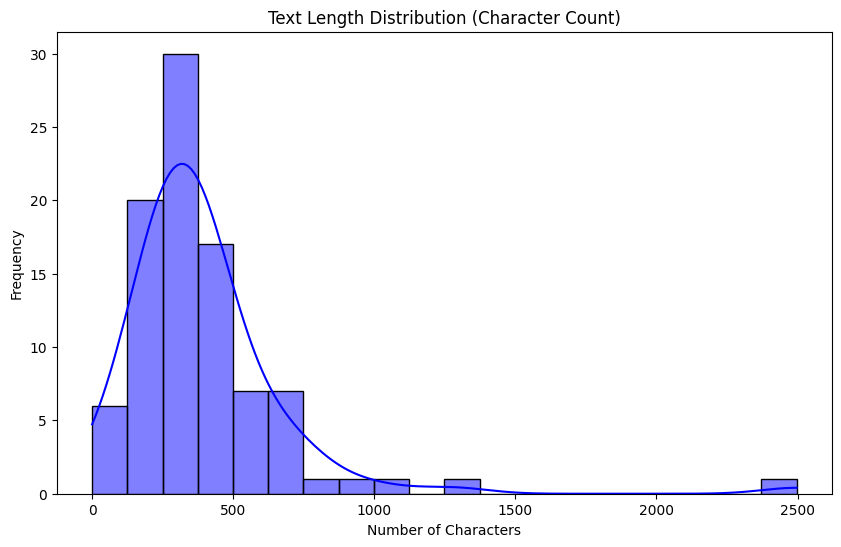

In [8]:
#1. Text Length Distribution (Character Count)
df['text_length'] = df['cleaned_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=20, kde=True, color="blue")
plt.title("Text Length Distribution (Character Count)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

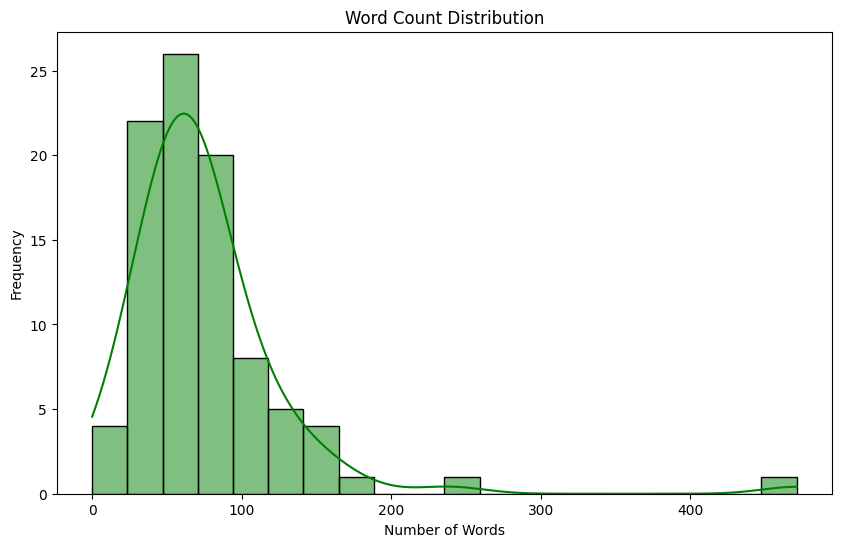

In [9]:
#2. Word Count Distribution
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=20, kde=True, color="green")
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

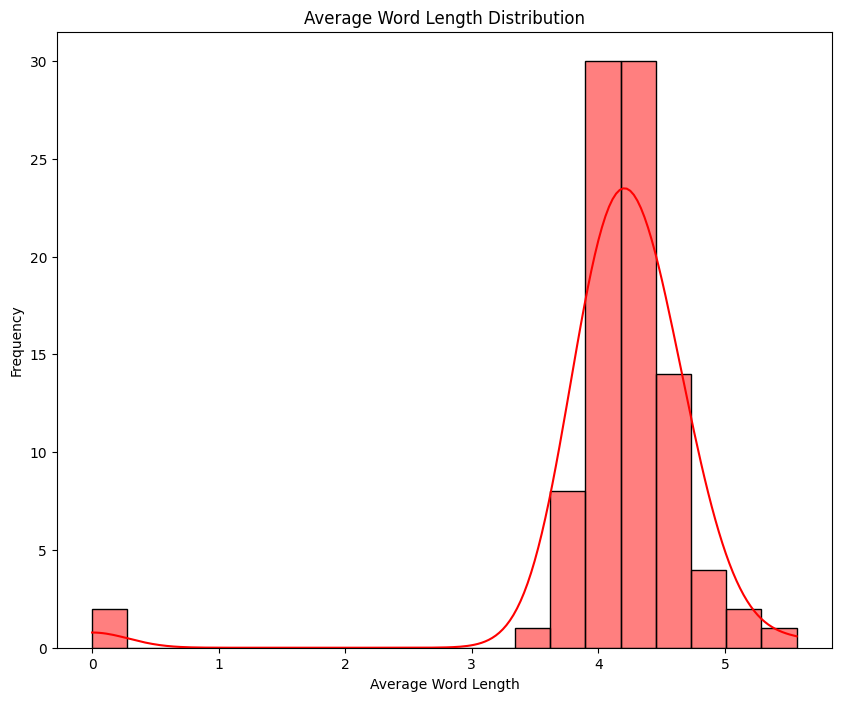

In [10]:
#3. Average Word Length Distribution
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

plt.figure(figsize=(10,8))
sns.histplot(df['avg_word_length'], bins=20, kde=True, color='red')
plt.title("Average Word Length Distribution")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

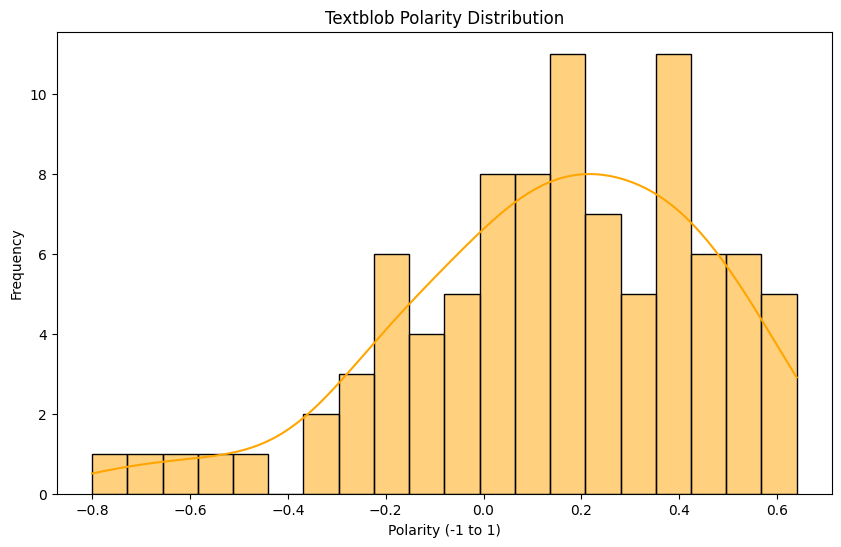

In [11]:
#4. Textblod Polarity Distribution
df['polarity_tb'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(df['polarity_tb'], bins=20, kde=True, color='orange')
plt.title('Textblob Polarity Distribution')
plt.xlabel('Polarity (-1 to 1)')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


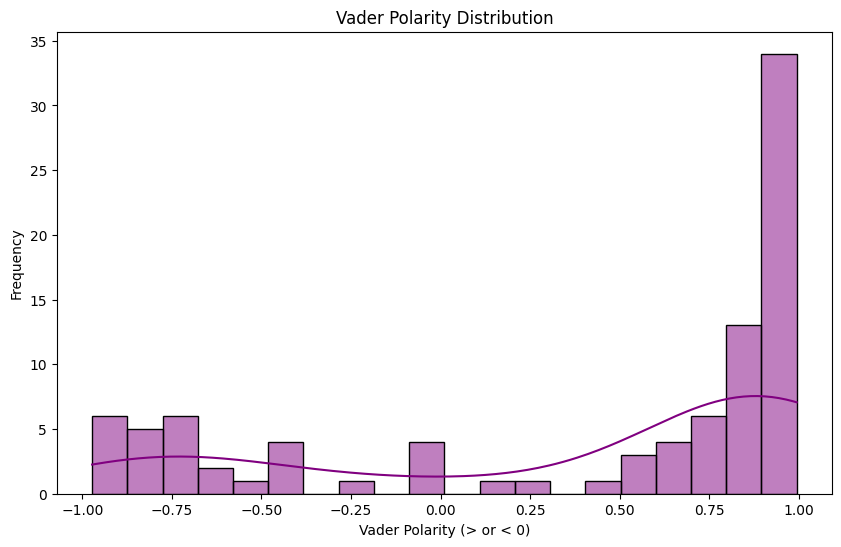

In [12]:
#5. Vader Polarity Distribution

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

df['polarity_vader'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
#df['binary_sentiment'] = df['polarity_vader'].apply(lambda x: 1 if x >= 0 else 0)

plt.figure(figsize=(10,6))
sns.histplot(df['polarity_vader'], bins=20, kde=True, color='purple')
plt.title('Vader Polarity Distribution')
plt.xlabel('Vader Polarity (> or < 0)')
plt.ylabel('Frequency')
plt.show()

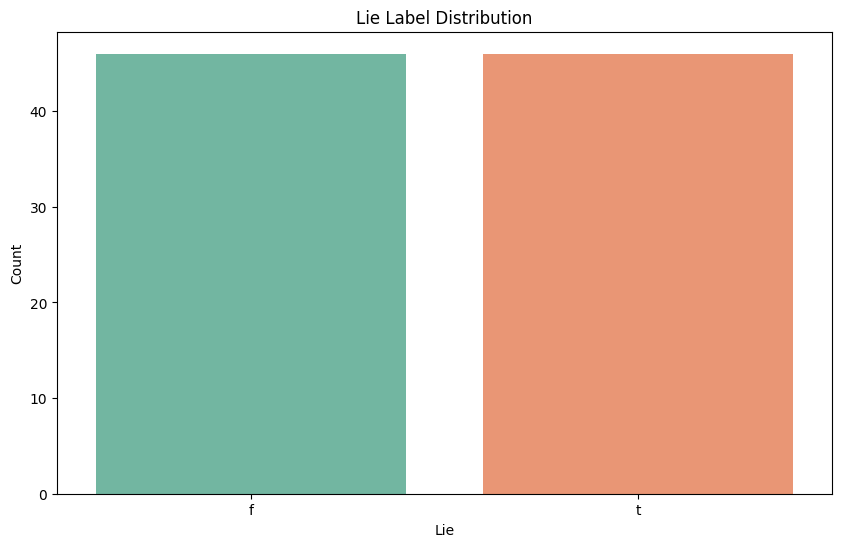

In [13]:
#6. Lie Label Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='lie', hue='lie', palette='Set2')
plt.title('Lie Label Distribution')
plt.xlabel('Lie')
plt.ylabel('Count')
plt.show()

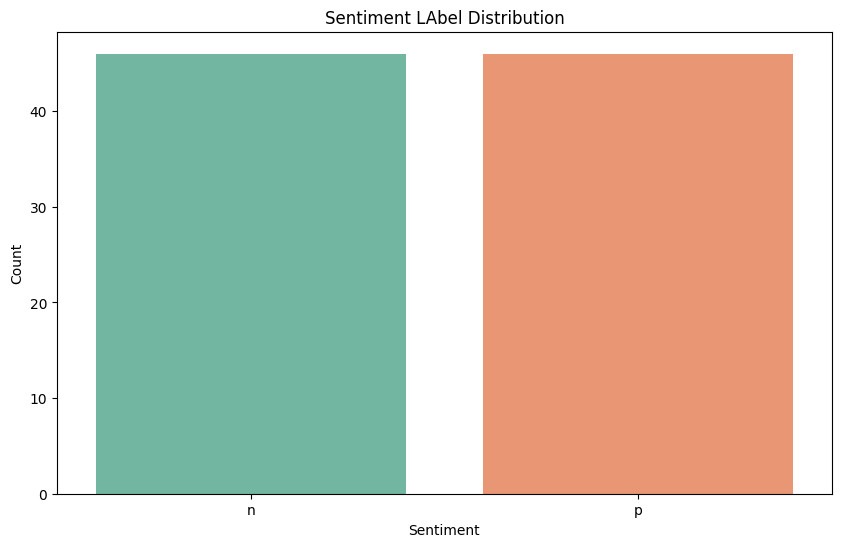

In [14]:
#7. Sentiment Label Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')
plt.title('Sentiment LAbel Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

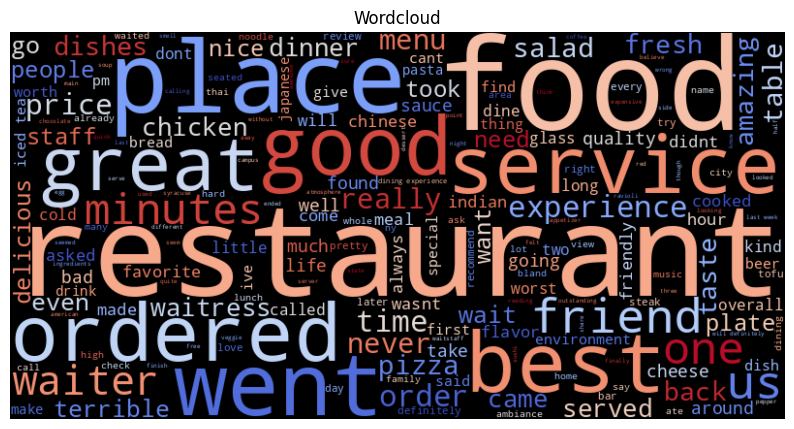

In [15]:
#8. Wordclouds
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap="coolwarm").generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud')
plt.show()

In [16]:
# Load spaCy for preprocessing
nlp = spacy.load("en_core_web_sm")

# Custom tokenizer for text preprocessing for word cloud
def preprocess_text_for_wc(text):
    doc = nlp(text.lower())
    return [token for token in doc if not token.is_stop ]

In [17]:
# Preprocess all text and calculate word frequencies
df['wc_processed_text'] = df['cleaned_text'].apply(preprocess_text_for_wc)
all_words = [str(word) for tokens in df['wc_processed_text'] for word in tokens]  # Ensure tokens are strings
word_freq = Counter(all_words)
word_freq

Counter({'mikes': 1,
         'pizza': 14,
         'high': 5,
         'point': 4,
         'ny': 5,
         'service': 28,
         'slow': 2,
         'quality': 10,
         'low': 3,
         'think': 4,
         'know': 3,
         'good': 29,
         'stick': 1,
         'premade': 1,
         'dishes': 14,
         'like': 22,
         'stuffed': 2,
         'pasta': 5,
         'salad': 15,
         'consider': 1,
         'dining': 10,
         'buffet': 3,
         'restaurant': 75,
         'marshall': 3,
         'street': 4,
         'lot': 4,
         'selection': 1,
         'american': 4,
         'japanese': 6,
         'chinese': 9,
         'got': 3,
         'free': 4,
         'drink': 2,
         'refill': 1,
         'different': 4,
         'kinds': 1,
         'dessert': 3,
         'staff': 10,
         'friendly': 9,
         'cheap': 3,
         'compared': 2,
         'syracuse': 4,
         'area': 5,
         'definitely': 10,
         'coming': 3,
   

In [18]:
# Sort and print word frequencies from most to least
sorted_word_freq = word_freq.most_common()
for word, freq in sorted_word_freq:
    print(f"{word}: {freq}")

food: 80
restaurant: 75
 : 56
nt: 43
place: 43
went: 34
best: 31
good: 29
service: 28
ordered: 27
great: 24
minutes: 23
experience: 23
like: 22
friends: 19
salad: 15
menu: 15
plate: 15
pizza: 14
dishes: 14
order: 14
time: 14
fresh: 14
amazing: 14
came: 13
served: 13
chicken: 13
waitress: 13
taste: 13
dinner: 12
waiter: 12
terrible: 12
wait: 12
took: 11
overall: 11
table: 11
people: 11
delicious: 11
want: 11
nice: 11
prices: 11
quality: 10
dining: 10
staff: 10
definitely: 10
found: 10
bad: 10
going: 10
life: 10
cheese: 10
sauce: 10
chinese: 9
friendly: 9
meal: 9
asked: 9
favorite: 9
cooked: 9
cold: 8
dine: 8
worst: 8
called: 8
come: 8
little: 8
long: 8
need: 8
indian: 8
glass: 8
said: 7
kind: 7
iced: 7
tea: 7
pm: 7
worth: 7
dish: 7
special: 7
bread: 7
find: 7
ve: 7
environment: 7
japanese: 6
hour: 6
recommend: 6
later: 6
steak: 6
ice: 6
price: 6
try: 6
waiters: 6
right: 6
bar: 6
pretty: 6
tofu: 6
high: 5
ny: 5
pasta: 5
area: 5
bring: 5
check: 5
family: 5
seated: 5
bland: 5
waited: 5
har

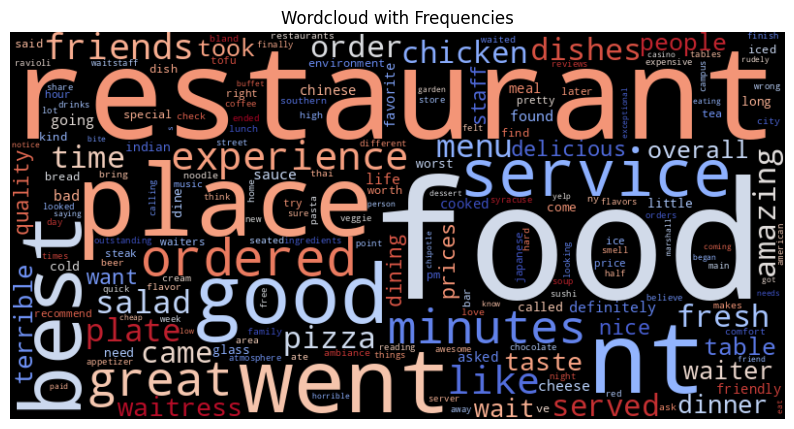

In [19]:
#9. Wordcloud with Frequencies
wordcloud_withFreq = WordCloud(width=800, height=400, background_color='black', colormap="coolwarm").generate_from_frequencies(word_freq)

plt.figure(figsize=(10,6))
plt.title('Wordcloud with Frequencies')
plt.imshow(wordcloud_withFreq, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# Subset the reviews by lie labels
t_reviews = ' '.join(df[df['lie'] == 't']['cleaned_text'])
f_reviews = ' '.join(df[df['lie'] == 'f']['cleaned_text'])

# Subset the reviews by sentiment labels
n_reviews = ' '.join(df[df['sentiment'] == 'n']['cleaned_text'])
p_reviews = ' '.join(df[df['sentiment'] == 'p']['cleaned_text'])

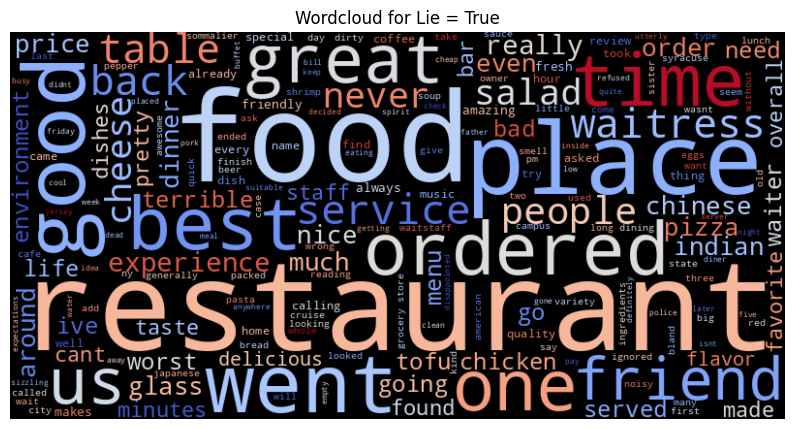

In [21]:
#10. Wordcloud: Reviews with lie = True
wordcloud_t = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(t_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_t, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Lie = True')
plt.show()

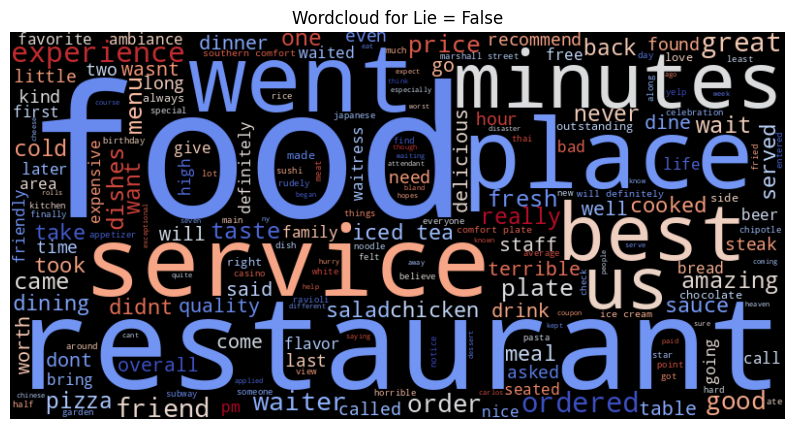

In [22]:
#11. Wordcloud: Reviews with lie = False
wordcloud_f = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(f_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_f, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Lie = False')
plt.show()

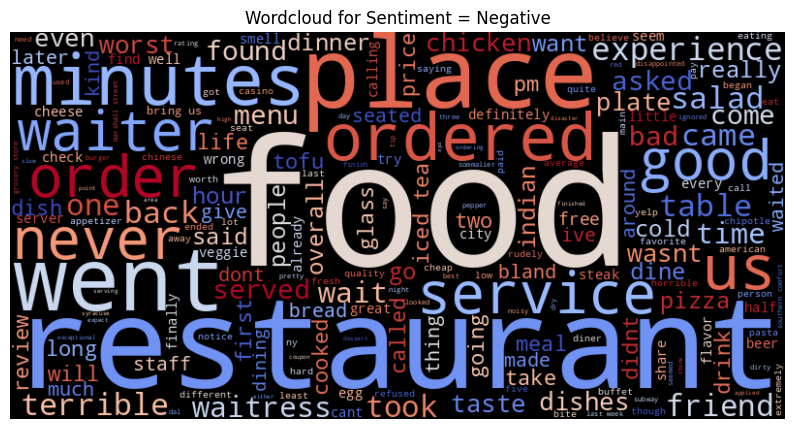

In [23]:
#12. Wordcloud: Reviews with sentiment = Negative
wordcloud_n = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(n_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_n, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Sentiment = Negative')
plt.show()

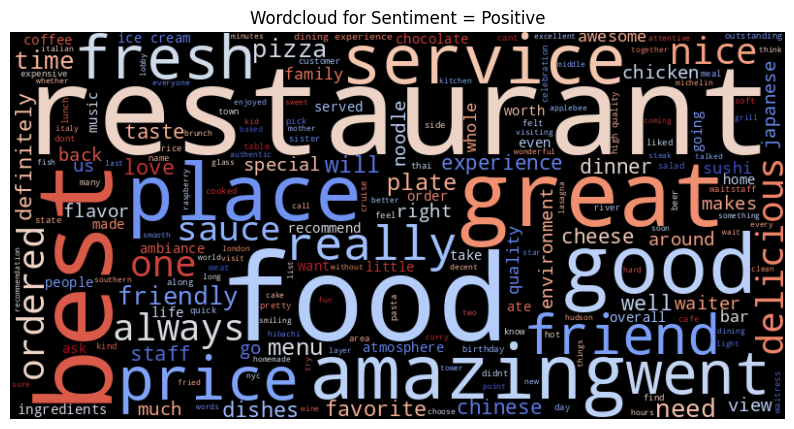

In [24]:
#13. Wordcloud 4: Reviews with sentiment = Positive
wordcloud_p = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(p_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_p, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Sentiment = Positive')
plt.show()

# **Methods and Models**

To address this classification problem, Multinomial Naive Bayes will be used to predict the sentiment and lie labels for the food review data.



**Multinomial Naive Bayes (MultinomialNB):**



MultinomialNB is a probabilistic classifier that uses Bayes' theorem to predict class membership. It assumes that the features (e.g., words or n-grams) are conditionally independent given the class label. This model is particularly effective for text classification tasks where word frequency is important.

**Experimental Design**

After completing EDA, we'll now lemmatize the text, then create multiple vectorizers utilizing various parameters. From there, we'll pass the vectorized text to MNB to train the model for prediction.

In [25]:
df.head()

,lie,sentiment,review,cleaned_text,text_length,word_count,avg_word_length,polarity_tb,polarity_vader,wc_processed_text
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'",mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where,231,44,4.272727,0.034000,0.5106,"[mikes, pizza, high, point, ny, service, slow, quality, low, think, know, good, pizza, stick, premade, dishes, like, stuffed, pasta, salad, consider, dining]"
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'",i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here,344,61,4.655738,0.146875,0.9391,"[like, buffet, restaurant, marshall, street, lot, selection, american, japanese, chinese, dishes, got, free, drink, free, refill, different, kinds, dessert, staff, friendly, cheap, compared, restaurant, syracuse, area, definitely, coming]"
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'",after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes,116,24,3.875000,0.000000,0.4939,"[went, shopping, friend, went, dodo, restaurant, dinner, found, worm, dishes]"
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '",olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden,211,43,3.930233,-0.056000,0.1616,"[olive, oil, garden, disappointing, expect, good, food, good, service, eat, meal, cold, got, waitor, manners, whatsoever, nt, olive, oil, garden]"
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are not ordering more. Well, never more. '",the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more,358,66,4.409091,0.236111,-0.8390,"[seven, heaven, restaurant, known, superior, service, experienced, week, disaster, waiter, notice, asked, , times, bring, menu, food, exceptional, took, , minutes, bring, check, spotted, finished, eating, ordering]"


In [26]:
def lemmatize_text(text):
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc])

In [27]:
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

In [28]:
# Compare the lemmatized and cleaned text to ensure application
df['cleaned_text'].head()

,cleaned_text
0,mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where
1,i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here
2,after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes
3,olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden
4,the seven heaven restaurant was never known for a superior service but what we experienced last week was a disaster the waiter would not notice us until we asked him times to bring us the menu the food was not exceptional either it took them though minutes to bring us a check after they spotted we finished eating and are not ordering more well never more


In [29]:
df['lemmatized_text'].head()

,lemmatized_text
0,mike pizza high point ny service be very slow and the quality be low you would think they would know at least how to make good pizza not stick to premade dish like stuff pasta or a salad you should consider dine else where
1,I really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dish we also get a free drink and free refill there be also different kind of dessert the staff be very friendly it be also quite cheap compare with the other restaurant in syracuse area I will definitely come back here
2,after I went shop with some of my friend we go to dodo restaurant for dinner I find worm in one of the dish
3,olive oil garden be very disappointing I expect good food and good service at least when I go out to eat the meal be cold when we get it and the waitor have no manner whatsoever do not go to the olive oil garden
4,the seven heaven restaurant be never know for a superior service but what we experience last week be a disaster the waiter would not notice we until we ask he time to bring we the menu the food be not exceptional either it take they though minute to bring we a check after they spot we finish eat and be not order more well never more


In [30]:
# Review sklearn stop words
sk_stops =list(set(ENGLISH_STOP_WORDS))
sk_stops

['him',
 'herein',
 'how',
 'always',
 'before',
 'none',
 'since',
 'beforehand',
 'sincere',
 'onto',
 'sixty',
 'former',
 'those',
 'show',
 'have',
 'twenty',
 'get',
 'its',
 'too',
 'each',
 'becomes',
 'hence',
 'cant',
 'once',
 'another',
 'already',
 'upon',
 'your',
 'itself',
 'namely',
 'seems',
 'except',
 'anywhere',
 'six',
 'hasnt',
 'keep',
 'fill',
 'something',
 'system',
 'fire',
 'last',
 'take',
 'for',
 'a',
 'call',
 'full',
 'hereupon',
 'as',
 'these',
 'such',
 'out',
 'five',
 'put',
 'eleven',
 'whether',
 'most',
 'move',
 'where',
 'three',
 'further',
 'over',
 'thick',
 'above',
 'bill',
 'de',
 'you',
 'has',
 'part',
 'latter',
 'still',
 'was',
 'whole',
 'if',
 'between',
 'what',
 'found',
 'at',
 'hereby',
 'cry',
 'whereby',
 'well',
 'eight',
 'ours',
 'we',
 'whereas',
 'mill',
 'third',
 'several',
 'ever',
 'after',
 'few',
 'two',
 'wherever',
 'in',
 'not',
 'serious',
 'yourselves',
 'on',
 'whose',
 'less',
 'cannot',
 'beside',
 'anyth

In [31]:
# Get and review the list of NLTK stopwords
nltk.download('stopwords')
nltk_stops = list(set(stopwords.words('english')))
nltk_stops

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['them',
 'than',
 'him',
 "haven't",
 'how',
 'd',
 'before',
 'that',
 'so',
 'of',
 'himself',
 'they',
 'and',
 'won',
 "should've",
 'who',
 "that'll",
 'those',
 'theirs',
 'me',
 'have',
 'couldn',
 'shouldn',
 'its',
 'too',
 'yourself',
 'each',
 'below',
 'once',
 'your',
 'into',
 'itself',
 'my',
 'there',
 'mightn',
 "needn't",
 'doesn',
 "won't",
 'other',
 'their',
 'o',
 'for',
 'a',
 'his',
 'as',
 'these',
 "couldn't",
 'about',
 'been',
 'such',
 "mustn't",
 'out',
 'both',
 'herself',
 'shan',
 'more',
 "you'd",
 'most',
 'where',
 "didn't",
 'by',
 'further',
 'over',
 'aren',
 'needn',
 'above',
 'themselves',
 'you',
 'then',
 'has',
 "it's",
 'up',
 'y',
 'was',
 're',
 'should',
 'weren',
 'what',
 'if',
 'between',
 'being',
 "hadn't",
 'were',
 'or',
 'at',
 'ourselves',
 "you're",
 's',
 "wouldn't",
 'she',
 'ours',
 'are',
 'can',
 'while',
 "isn't",
 'we',
 'some',
 'ma',
 'an',
 'after',
 'few',
 'here',
 'in',
 'our',
 "you'll",
 'is',
 'not',
 've',
 'n

In [32]:
# Customize stops
my_stops = ['food','restaurant', ' ', 'or', 'also', 'for,','nt', 'place', 'went', 'they','a','i','he', 'she', 'we', 'you', 'the', 'to', 'in', 'if', 'at', 'of', 'on', 'your', 'by','and', 'but', 'when', 'who', 'why', 'with', 'work', 'write', 've']

In [33]:
# Review dataframe
df.head()

,lie,sentiment,review,cleaned_text,text_length,word_count,avg_word_length,polarity_tb,polarity_vader,wc_processed_text,lemmatized_text
0,f,n,"'Mike\'s Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.'",mikes pizza high point ny service was very slow and the quality was low you would think they would know at least how to make good pizza not stick to premade dishes like stuffed pasta or a salad you should consider dining else where,231,44,4.272727,0.034000,0.5106,"[mikes, pizza, high, point, ny, service, slow, quality, low, think, know, good, pizza, stick, premade, dishes, like, stuffed, pasta, salad, consider, dining]",mike pizza high point ny service be very slow and the quality be low you would think they would know at least how to make good pizza not stick to premade dish like stuff pasta or a salad you should consider dine else where
1,f,n,"'i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here.'",i really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming back here,344,61,4.655738,0.146875,0.9391,"[like, buffet, restaurant, marshall, street, lot, selection, american, japanese, chinese, dishes, got, free, drink, free, refill, different, kinds, dessert, staff, friendly, cheap, compared, restaurant, syracuse, area, definitely, coming]",I really like this buffet restaurant in marshall street they have a lot of selection of american japanese and chinese dish we also get a free drink and free refill there be also different kind of dessert the staff be very friendly it be also quite cheap compare with the other restaurant in syracuse area I will definitely come back here
2,f,n,"'After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes .'",after i went shopping with some of my friend we went to dodo restaurant for dinner i found worm in one of the dishes,116,24,3.875000,0.000000,0.4939,"[went, shopping, friend, went, dodo, restaurant, dinner, found, worm, dishes]",after I went shop with some of my friend we go to dodo restaurant for dinner I find worm in one of the dish
3,f,n,"'Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don\'t go to the Olive Oil Garden. '",olive oil garden was very disappointing i expect good food and good service at least when i go out to eat the meal was cold when we got it and the waitor had no manners whatsoever dont go to the olive oil garden,211,43,3.930233,-0.056000,0.1616,"[olive, oil, garden, disappointing, expect, good, food, good, service, eat, meal, cold, got, waitor, manners, whatsoever, nt, olive, oil, garden]",olive oil garden be very disappointing I expect good food and good service at least when I go out to eat the meal be cold when we get it and the waitor have no manner whatsoever do not go to the olive oil garden
4,f,n,"'The Seven Heaven restaurant was never known for a superior service but what we experienced last week was a disaster. The waiter would not notice us until we asked him 4 times to bring us the menu. The food was not exceptional either. It took them though 2 minutes to bring us a check after they spotted we finished eating and are no

In [34]:
# Split the data into training and testing sets
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    df['lemmatized_text'],
    df['sentiment'],
    test_size=0.18,
    random_state=42,
    stratify=df['sentiment']  # Ensures balanced label distribution in train/test sets
)

# Display the split
print(f"Training set size: {len(X_train_sentiment)}")
#X_train_sentiment.head()
print(f"Testing set size: {len(X_test_sentiment)}")
#X_test_sentiment.head()

Training set size: 75
Testing set size: 17


In [35]:
X_train_lie, X_test_lie, y_train_lie, y_test_lie = train_test_split(
    df['lemmatized_text'],
    df['lie'],
    test_size=0.18,
    random_state=42,
    stratify=df['lie']
)

# Display the split
print(f"Training set size: {len(X_train_lie)}")
#X_train_lie.head()
print(f"Testing set size: {len(X_test_lie)}")
#X_train_lie.head()

Training set size: 75
Testing set size: 17


**Initialize vectorizers:**

Here I'll be trying out 5 different experimental designs in regards to the vectorizers; I'll only be using the TfidfVectorizer for these experiments. The first implementation will be a base implementation with no parameters, the second implementation will use a created stop words list, the third implementation will use the nltk stop word list, the fourth implementation will use the sklearn stop word list, and the final implementation will be utilize ngrams with the nltk stop words list. I've created five vectorizers that will be used for both classification tasks, and as we'll see the current settings favor one of the tasks.

In [36]:
base_tfidf = TfidfVectorizer()
base_tfidf_vec = base_tfidf.fit_transform(df['lemmatized_text'])
base_tfidf.get_feature_names_out()

array(['abc', 'about', 'abruptly', ..., 'your', 'yourself', 'yuenan'],
      dtype=object)

In [37]:
base_tfidf_my_stops = TfidfVectorizer(stop_words=my_stops)
base_tfidf_my_stops_vec = base_tfidf_my_stops.fit_transform(df['lemmatized_text'])
base_tfidf_my_stops.get_feature_names_out()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['for'] not in stop_words.
  warnings.warn(


array(['abc', 'about', 'abruptly', ..., 'york', 'yourself', 'yuenan'],
      dtype=object)

In [38]:
nltk_tfidf = TfidfVectorizer(stop_words= nltk_stops)
nltk_tfidf_vec = nltk_tfidf.fit_transform(df['lemmatized_text'])
nltk_tfidf.get_feature_names_out()

array(['abc', 'abruptly', 'absolutely', ..., 'yesterday', 'york',
       'yuenan'], dtype=object)

In [39]:
sk_tfidf = TfidfVectorizer(stop_words= sk_stops)
sk_tfidf_vec = sk_tfidf.fit_transform(df['lemmatized_text'])
sk_tfidf.get_feature_names_out()

array(['abc', 'abruptly', 'absolutely', ..., 'yesterday', 'york',
       'yuenan'], dtype=object)

In [76]:
ngram_nltk_tfidf = TfidfVectorizer()
ngram_nltk_tfidf_vec = ngram_nltk_tfidf.fit_transform(df['lemmatized_text'])
ngram_nltk_tfidf.get_feature_names_out()

array(['abc', 'about', 'abruptly', ..., 'your', 'yourself', 'yuenan'],
      dtype=object)

In [77]:
# Define model pipelines and parameter grids

models = {
    'Naive Bayes Base': {
        'pipeline': Pipeline([
            ('vectorizer', base_tfidf),  # stop_words=my_stops, max_features=75, min_df, stop_words='english', ngram_range=(1, 2), max_features=50, TfidfVectorizer(stop_words=combined_stop_words)
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [15, 25, 50, 100],
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5,0.75, 1.0]
        }
    },
      'Naive Bayes Base My Stops': {
        'pipeline': Pipeline([
            ('vectorizer', base_tfidf_my_stops),
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [15, 25, 50, 100],
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5,0.75, 1.0]
        }
    },
       'Naive Bayes NLTK Stops': {
        'pipeline': Pipeline([
            ('vectorizer', nltk_tfidf),
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [15, 25, 50, 100],
            'classifier__alpha': [0.01, 0.1, 0.25,0.5,0.75, 1.0]
        }
    },

      'Naive Bayes SK Stops': {
        'pipeline': Pipeline([
            ('vectorizer', sk_tfidf),
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [15, 25, 50, 100],
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
        }
    },
      'Naive Bayes NGrams': {
        'pipeline': Pipeline([
            ('vectorizer', ngram_nltk_tfidf),
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [15, 25, 50, 100],
            'vectorizer__ngram_range': [(1,3),(2, 2)],
            'classifier__alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
        }
    }
}

In [78]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)

In [79]:
# Train each model
sentiment_results = {}
for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model_info['pipeline'],
        param_grid=model_info['param_grid'],
        cv=cv,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_sentiment, y_train_sentiment)  # Train on the training set
    sentiment_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'grid_search': grid_search
    }

Training Naive Bayes Base...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes Base My Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['for'] not in stop_words.
  warnings.warn(


Training Naive Bayes NLTK Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes SK Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes NGrams...
Fitting 12 folds for each of 48 candidates, totalling 576 fits


In [80]:
# Train each model
lie_results = {}
for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model_info['pipeline'],
        param_grid=model_info['param_grid'],
        cv=cv,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_lie, y_train_lie)  # Train on the training set
    lie_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'grid_search': grid_search
    }

Training Naive Bayes Base...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes Base My Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['for'] not in stop_words.
  warnings.warn(


Training Naive Bayes NLTK Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes SK Stops...
Fitting 12 folds for each of 24 candidates, totalling 288 fits
Training Naive Bayes NGrams...
Fitting 12 folds for each of 48 candidates, totalling 576 fits



Evaluating Naive Bayes Base on the test set...
Naive Bayes Base Metrics:
Accuracy: 0.94
F1 Score: 0.94
Recall: 1.00


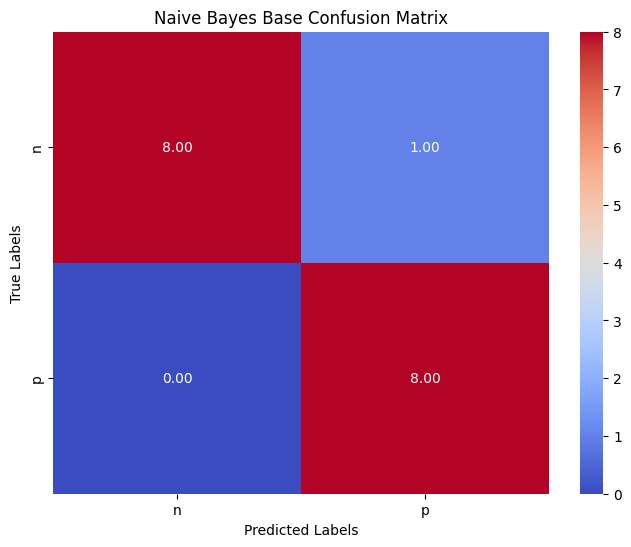


Evaluating Naive Bayes Base My Stops on the test set...
Naive Bayes Base My Stops Metrics:
Accuracy: 0.71
F1 Score: 0.71
Recall: 0.75


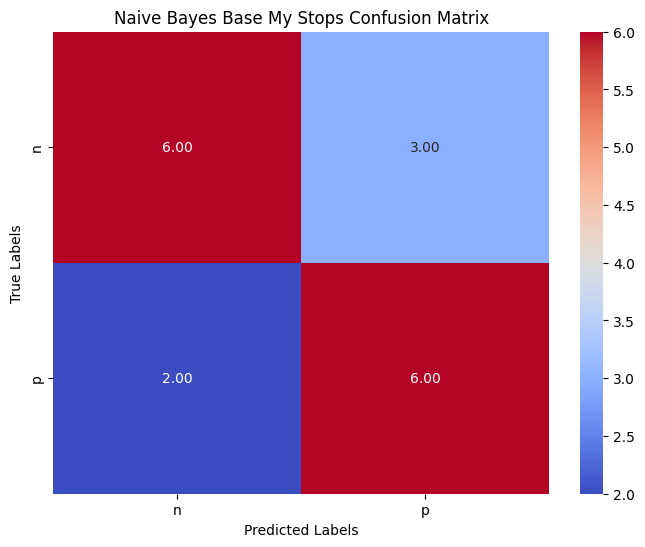


Evaluating Naive Bayes NLTK Stops on the test set...
Naive Bayes NLTK Stops Metrics:
Accuracy: 0.88
F1 Score: 0.86
Recall: 0.75


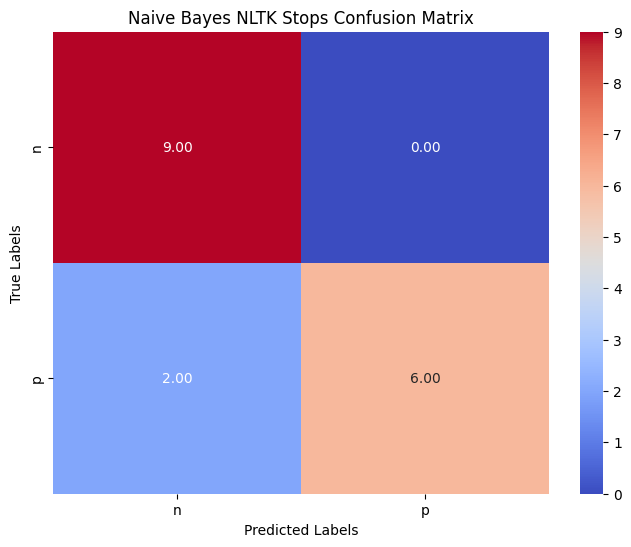


Evaluating Naive Bayes SK Stops on the test set...
Naive Bayes SK Stops Metrics:
Accuracy: 0.76
F1 Score: 0.75
Recall: 0.75


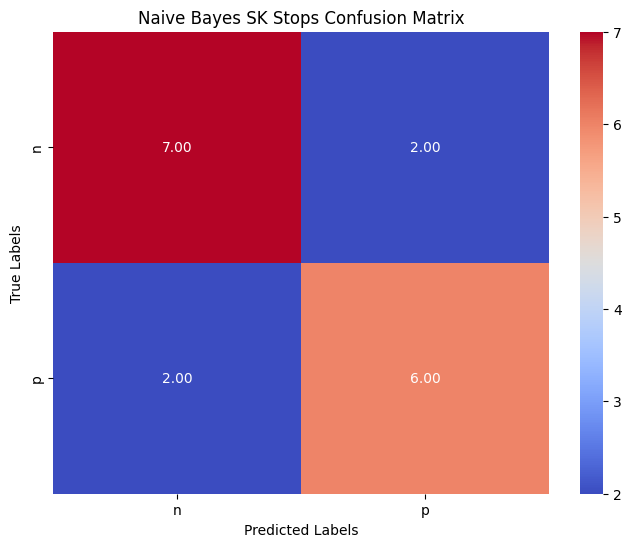


Evaluating Naive Bayes NGrams on the test set...
Naive Bayes NGrams Metrics:
Accuracy: 0.88
F1 Score: 0.88
Recall: 0.88


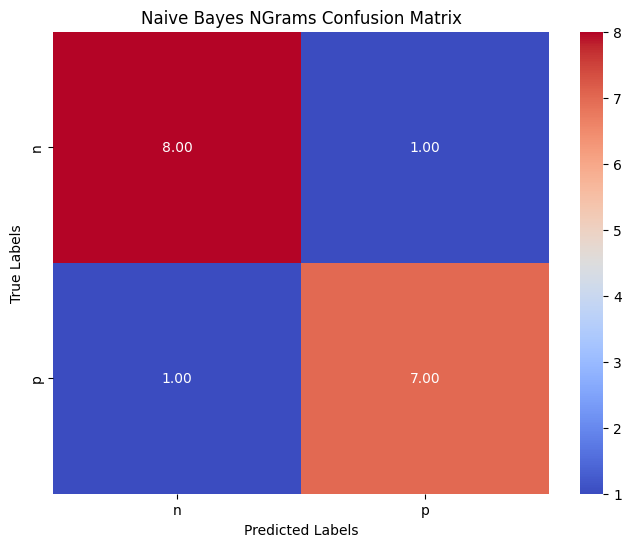

In [81]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize a list to store metrics for each model
sentiment_metrics = []

# Evaluate on the testing set
for model_name, model_info in sentiment_results.items():
    print(f"\nEvaluating {model_name} on the test set...")
    best_model = model_info['grid_search'].best_estimator_
    sentiment_predictions = best_model.predict(X_test_sentiment)  # Predict on the testing set

    # Calculate metrics
    accuracy = accuracy_score(y_test_sentiment, sentiment_predictions)
    f1 = f1_score(y_test_sentiment, sentiment_predictions, pos_label='p')  # Use average='weighted' for multi-class
    recall = recall_score(y_test_sentiment, sentiment_predictions, pos_label='p')  # "" ""

    # Append metrics to the list
    sentiment_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall
    })

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Recall: {recall:.2f}")

    # Create a confusion matrix
    cm = confusion_matrix(y_test_sentiment, sentiment_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=np.unique(y_test_sentiment), yticklabels=np.unique(y_test_sentiment))
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [82]:
# Create a DataFrame for comparison
sentiment_metrics_df = pd.DataFrame(sentiment_metrics)

# Display the metrics comparison
print("\n Sentiment Metrics Comparison:")
print(sentiment_metrics_df)

# Save metrics to a CSV file
sentiment_metrics_df.to_csv("sentiment_model_metrics_comparison.csv", index=False)


 Sentiment Metrics Comparison:
                       Model  Accuracy  F1 Score  Recall
0           Naive Bayes Base  0.941176  0.941176   1.000
1  Naive Bayes Base My Stops  0.705882  0.705882   0.750
2     Naive Bayes NLTK Stops  0.882353  0.857143   0.750
3       Naive Bayes SK Stops  0.764706  0.750000   0.750
4         Naive Bayes NGrams  0.882353  0.875000   0.875



Evaluating Naive Bayes Base on the test set...
Naive Bayes Base Metrics:
Accuracy: 0.41
F1 Score: 0.29
Recall: 0.25


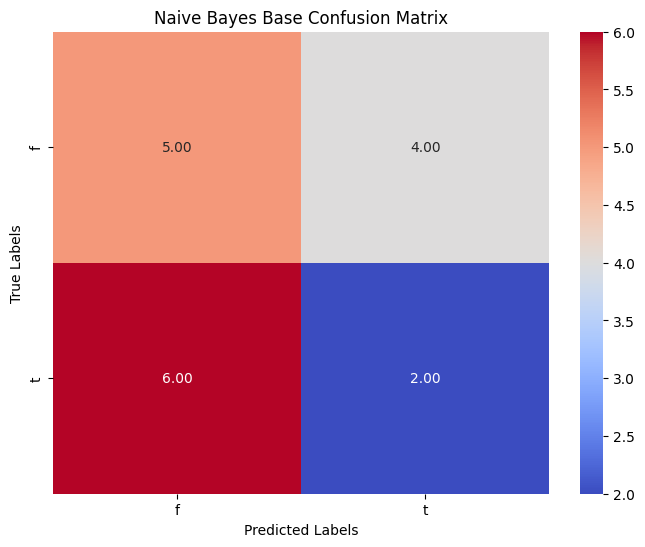


Evaluating Naive Bayes Base My Stops on the test set...
Naive Bayes Base My Stops Metrics:
Accuracy: 0.24
F1 Score: 0.13
Recall: 0.12


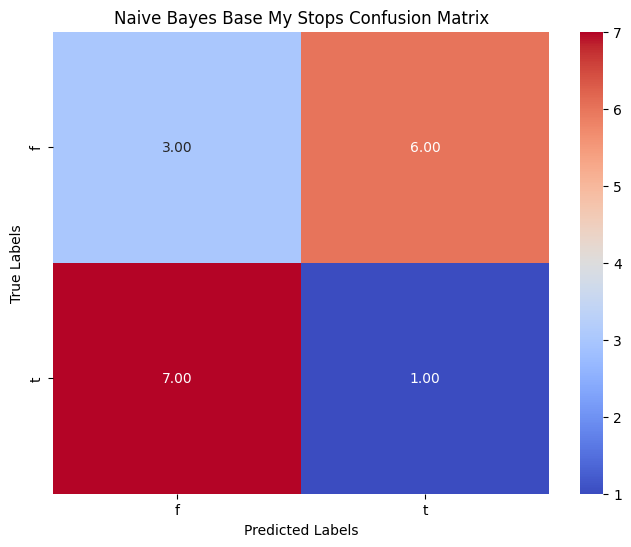


Evaluating Naive Bayes NLTK Stops on the test set...
Naive Bayes NLTK Stops Metrics:
Accuracy: 0.65
F1 Score: 0.57
Recall: 0.50


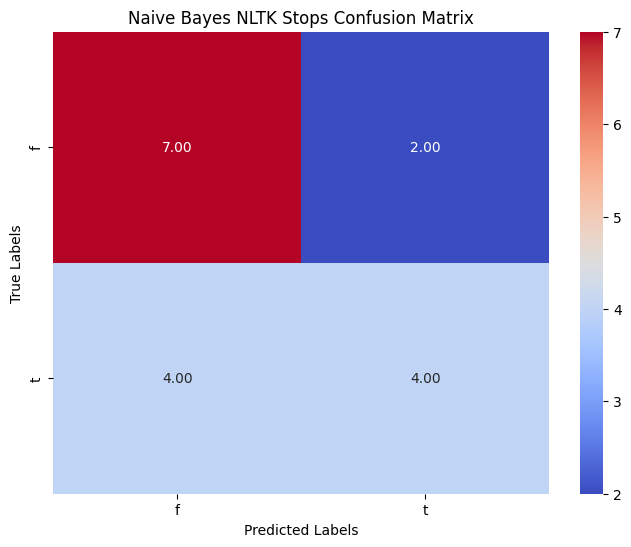


Evaluating Naive Bayes SK Stops on the test set...
Naive Bayes SK Stops Metrics:
Accuracy: 0.53
F1 Score: 0.50
Recall: 0.50


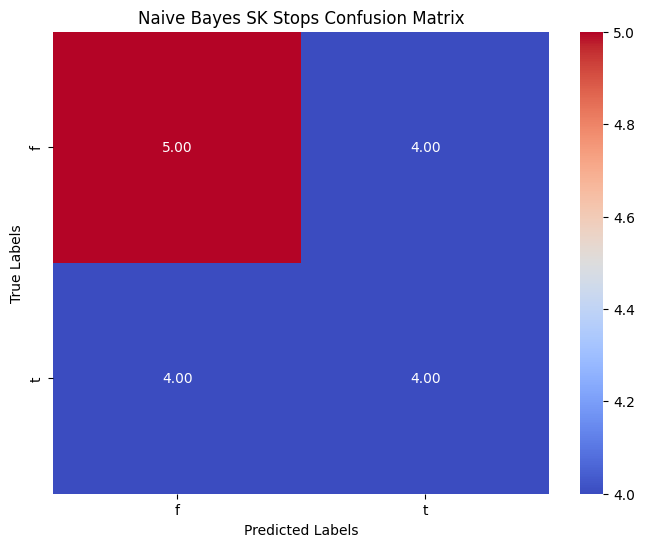


Evaluating Naive Bayes NGrams on the test set...
Naive Bayes NGrams Metrics:
Accuracy: 0.53
F1 Score: 0.50
Recall: 0.50


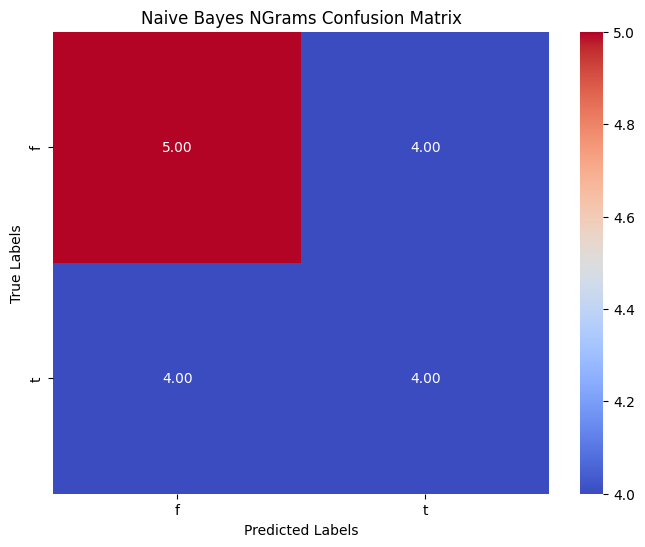

In [83]:
# Initialize a list to store metrics for each model
lie_metrics = []

# Evaluate on the testing set
for model_name, model_info in lie_results.items():
    print(f"\nEvaluating {model_name} on the test set...")
    best_model = model_info['grid_search'].best_estimator_
    lie_predictions = best_model.predict(X_test_lie)  # Predict on the testing set

    # Calculate metrics
    accuracy = accuracy_score(y_test_lie, lie_predictions)
    f1 = f1_score(y_test_lie, lie_predictions, pos_label='t')  # Use average='weighted' for multi-class
    recall = recall_score(y_test_lie, lie_predictions, pos_label='t')  # "" ""

    # Append metrics to the list
    lie_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall
    })

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Recall: {recall:.2f}")

    # Create a confusion matrix
    cm = confusion_matrix(y_test_lie, lie_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=np.unique(y_test_lie), yticklabels=np.unique(y_test_lie))
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [84]:
# Create a DataFrame for comparison
lie_metrics_df = pd.DataFrame(lie_metrics)

# Display the metrics comparison
print("\nLie Metrics Comparison:")
print(lie_metrics_df)

# Save metrics to a CSV file
lie_metrics_df.to_csv("lie_model_metrics_comparison.csv", index=False)


Lie Metrics Comparison:
                       Model  Accuracy  F1 Score  Recall
0           Naive Bayes Base  0.411765  0.285714   0.250
1  Naive Bayes Base My Stops  0.235294  0.133333   0.125
2     Naive Bayes NLTK Stops  0.647059  0.571429   0.500
3       Naive Bayes SK Stops  0.529412  0.500000   0.500
4         Naive Bayes NGrams  0.529412  0.500000   0.500


# **Results**


Using identical vectorizers for the Lie and Sentiment classification tasks produced very different results, as expected. For the Sentiment classification task, the base TFIDF vectorizer (with no parameters set) performed the best, followed by the base TFIDF vectorizer that utilized ngrams, then the base TFIDF vectorizer with NLTK stop words removed. Generally the removal of stop words seemed to negatively impact model performance. For the Lie classification task, these vectorizers didn't prove very effective, as only one model (the base TFIDF vectorizer with NLTK stop words removed) performed better than general guessing. To effectively create a robust model, specifically created vectorizers would need to be implemented, as lie detection appears to be a harder task to successfully model.

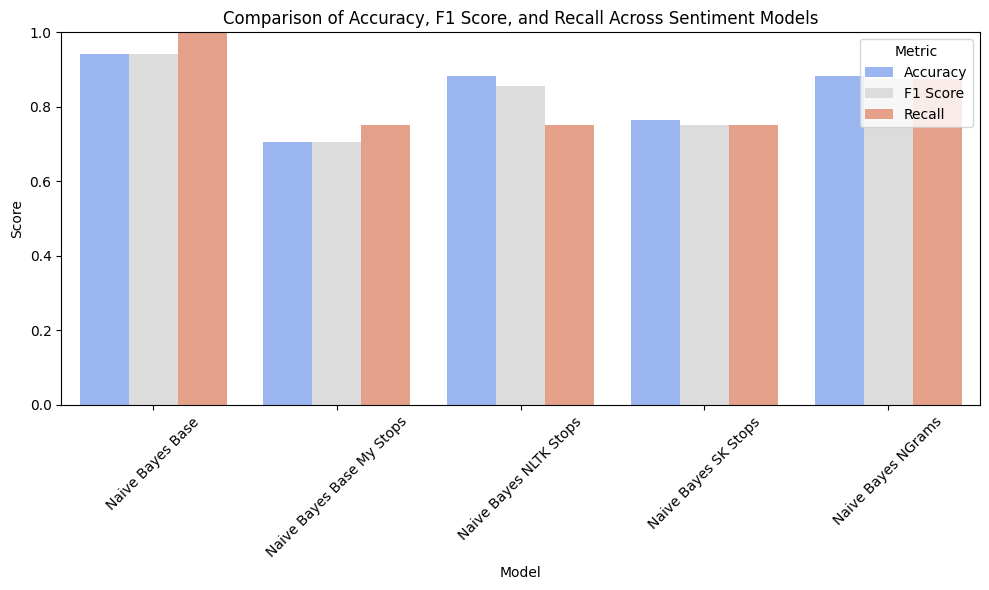

In [85]:
# Melt the DataFrame for easy plotting
sentiment_metrics_melted = sentiment_metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_metrics_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')

plt.title("Comparison of Accuracy, F1 Score, and Recall Across Sentiment Models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xlabel("Model")
plt.legend(title="Metric", loc="upper right")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

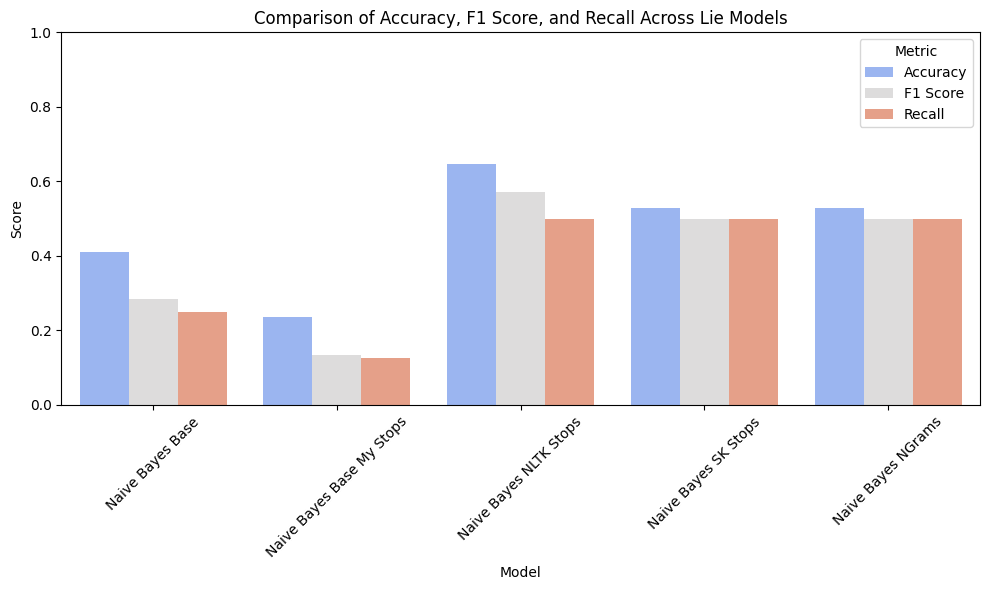

In [86]:
# Melt the DataFrame for easy plotting
lie_metrics_melted = lie_metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(data=lie_metrics_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')

plt.title("Comparison of Accuracy, F1 Score, and Recall Across Lie Models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xlabel("Model")
plt.legend(title="Metric", loc="upper right")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# **Conclusion**

To further improve upon the models, additional experimental design is necessary. For the sentiment classification task, additional things can be tried such as various combinations of test split, min_df, and ngrams. For the Lie classification task, a deeper review of the NLTK and SK Learn stop words, along with the True and False WordClouds, and use of min_df, would potentially improve the model performance. Also, some outside/supplemental reading on lie detection classification would also be helpful, as those patterns appear to be a bit more insidious to recognize for the models.

In [88]:
# Creating HTML file in colab

%%shell
jupyter nbconvert --to html /content/Nikita_Ramsey_Week4_HW (1).ipynb

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `jupyter nbconvert --to html /content/Nikita_Ramsey_Week4_HW (1).ipynb'


CalledProcessError: Command 'jupyter nbconvert --to html /content/Nikita_Ramsey_Week4_HW (1).ipynb
' returned non-zero exit status 2.